In [ ]:
!pip install yfinance
import yfinance as yf # Import the yfinance library and assign it to the alias 'yf'

# Download data (5 vectors: Open, High, Low, Close, Volume)
data = yf.download('UNIONBANK.NS', start='2020-01-01', end='2024-11-30')

[*********************100%***********************]  1 of 1 completed


In [ ]:
!pip install yfinance
!pip install scikit-learn # Install scikit-learn, the library containing MinMaxScaler
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler # Import MinMaxScaler from sklearn.preprocessing


# Download data (5 vectors: Open, High, Low, Close, Volume)
data = yf.download('UNIONBANK.NS', start='2020-01-01', end='2024-11-30')

# Calculate RSI manually
def calculate_rsi(series, period=14):
    delta = series.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Calculate SMA_50
data['SMA_50'] = data['Close'].rolling(window=50).mean() # Calculate SMA_50 and add it to the DataFrame

# Calculate RSI and add it to the DataFrame
data['RSI'] = calculate_rsi(data['Close'])

def custom_formula(sma, rsi):
    return sma * (rsi / 100)  # New composite indicator, SMA modulated by RSI

data['Composite_Indicator'] = custom_formula(data['SMA_50'], data['RSI'])
# Scaling data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']].values.reshape(-1, 1))

# LSTM Model Preparation
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - loss: 0.0468
Epoch 2/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - loss: 0.0090
Epoch 3/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - loss: 0.0077
Epoch 4/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - loss: 0.0073
Epoch 5/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - loss: 0.0052
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step


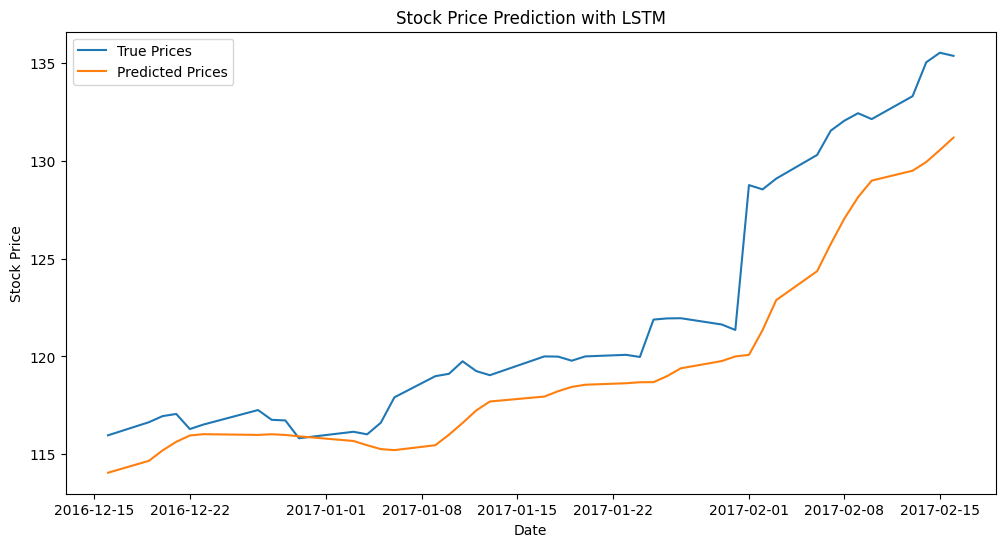

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Load data
# Original URL: url = 'https://raw.githubusercontent.com/datacamp/datacamp_fictitious_stocks/main/AMZN.csv'
# Updated URL to reflect the correct file path:
url = 'https://raw.githubusercontent.com/plotly/datasets/master/finance-charts-apple.csv'
data = pd.read_csv(url)

# Assuming the 'Date' column is present and in the correct format, continue with processing.
data = data[['Date', 'AAPL.Close']]  # Use Date and AAPL.Close (adjust if the column name is different)
data.columns = ['Date', 'Close'] #Rename the column to 'Close'
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Create training and testing datasets
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[:training_data_len]
test_data = scaled_data[training_data_len:]

# Prepare training dataset
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i-time_step:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape data for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=5)

# Predictions
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

# Evaluate the model
true_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot results
plt.figure(figsize=(12, 6))

# Adjust the x-axis to match the length of true_prices
plt.plot(data.index[-len(true_prices):], true_prices, label="True Prices")
plt.plot(data.index[-len(predicted_prices):], predicted_prices, label="Predicted Prices")

plt.legend()
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction with LSTM')
plt.show()

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import pandas_datareader as data

In [4]:
!pip install yfinance
import yfinance as yf
import pandas as pd

start = '2020-01-01'
end = '2024-11-30'

# Use yfinance to download data instead of pandas_datareader
df = yf.download('UNIONBANK.NS', start=start, end=end)
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,UNIONBANK.NS,UNIONBANK.NS,UNIONBANK.NS,UNIONBANK.NS,UNIONBANK.NS
Date,,,,,
2020-01-01,48.708157,49.645710,48.350995,49.154611,4807629
2020-01-02,49.243900,49.511772,48.618864,48.618864,5754393
2020-01-03,48.886742,49.556423,48.529577,49.199258,5525524
2020-01-06,47.279507,48.484932,47.145569,48.350998,5204531
2020-01-07,47.056274,48.484927,46.654465,47.859890,5527537


In [5]:
df= df.reset_index()
df.head()

Price,Date,Close,High,Low,Open,Volume
Ticker,,UNIONBANK.NS,UNIONBANK.NS,UNIONBANK.NS,UNIONBANK.NS,UNIONBANK.NS
0,2020-01-01,48.708157,49.645710,48.350995,49.154611,4807629
1,2020-01-02,49.243900,49.511772,48.618864,48.618864,5754393
2,2020-01-03,48.886742,49.556423,48.529577,49.199258,5525524
3,2020-01-06,47.279507,48.484932,47.145569,48.350998,5204531
4,2020-01-07,47.056274,48.484927,46.654465,47.859890,5527537


In [7]:
df=df.drop(['Date'],axis=1)
df.head()

<ipython-input-7-7cf5ca49c2dd>:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df=df.drop(['Date'],axis=1)


Price,Close,High,Low,Open,Volume
Ticker,UNIONBANK.NS,UNIONBANK.NS,UNIONBANK.NS,UNIONBANK.NS,UNIONBANK.NS
0,48.708157,49.645710,48.350995,49.154611,4807629
1,49.243900,49.511772,48.618864,48.618864,5754393
2,48.886742,49.556423,48.529577,49.199258,5525524
3,47.279507,48.484932,47.145569,48.350998,5204531
4,47.056274,48.484927,46.654465,47.859890,5527537


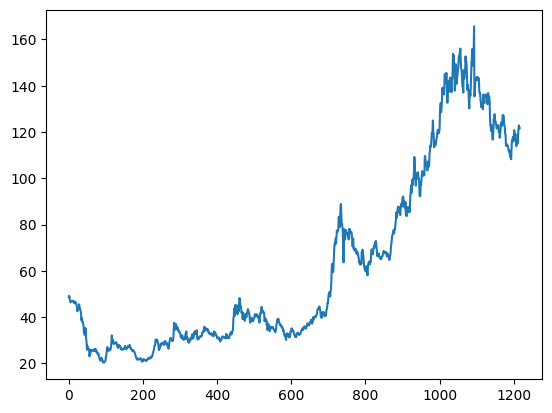

In [8]:
plt.plot(df.Close)

In [9]:
df

Price,Close,High,Low,Open,Volume
Ticker,UNIONBANK.NS,UNIONBANK.NS,UNIONBANK.NS,UNIONBANK.NS,UNIONBANK.NS
0,48.708157,49.645710,48.350995,49.154611,4807629
1,49.243900,49.511772,48.618864,48.618864,5754393
2,48.886742,49.556423,48.529577,49.199258,5525524
3,47.279507,48.484932,47.145569,48.350998,5204531
4,47.056274,48.484927,46.654465,47.859890,5527537
...,...,...,...,...,...
1212,119.790001,121.339996,117.089996,117.089996,17624755
1213,121.400002,121.650002,119.360001,119.900002,6930332
1214,122.879997,123.500000,120.239998,122.440002,7535056


In [12]:
ma100 = df.Close.rolling(100).mean()
ma100

Ticker,UNIONBANK.NS
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
1212,122.592131
1213,122.499566
1214,122.401633
1215,122.294237


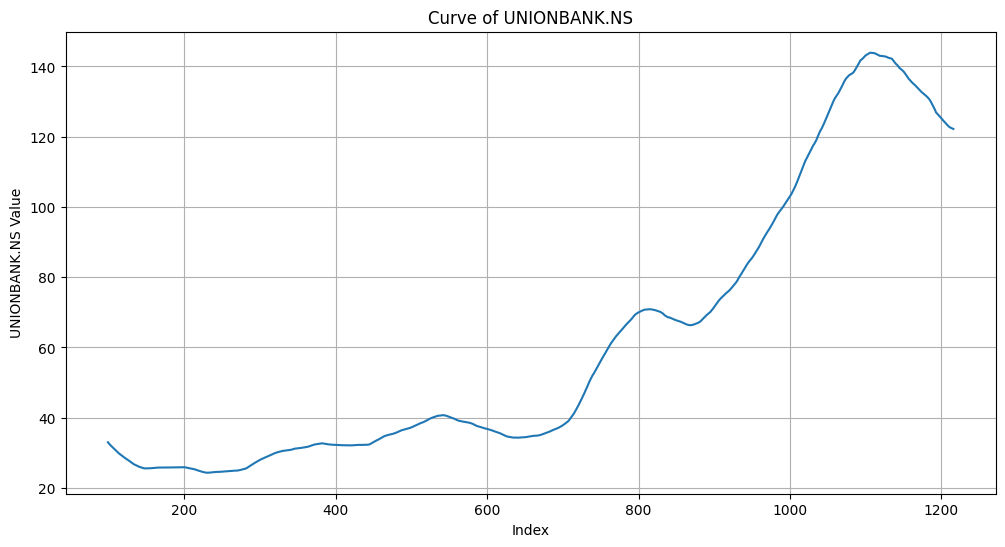

In [13]:


import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
plt.plot(ma100['UNIONBANK.NS'])
plt.xlabel('Index')  # Assuming index represents time or another relevant dimension
plt.ylabel('UNIONBANK.NS Value')
plt.title('Curve of UNIONBANK.NS')
plt.grid(True)
plt.show()


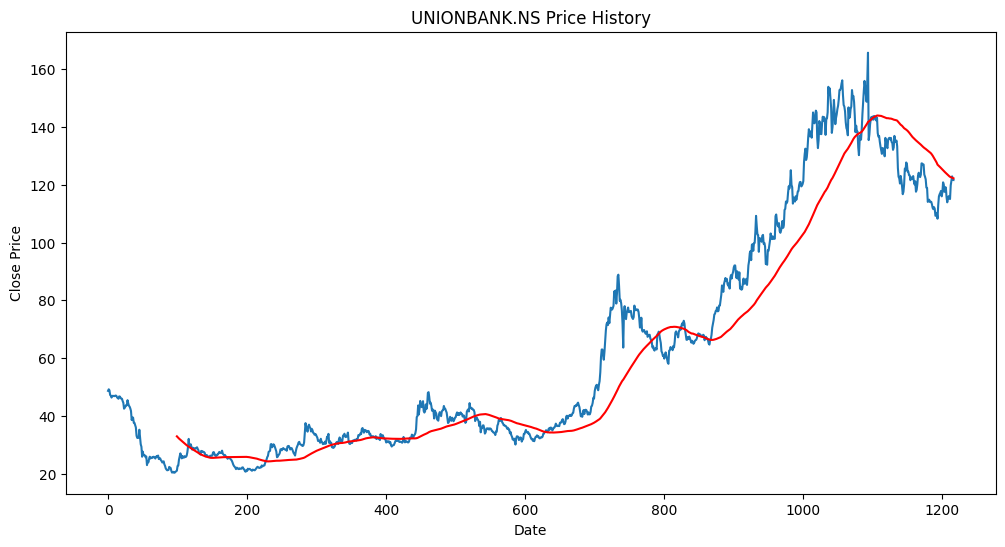

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(df.Close)
plt.plot(ma100, 'r')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('UNIONBANK.NS Price History')
plt.show()

In [16]:
ma200 = df.Close.rolling(200).mean() # Change 'close' to 'Close'
ma200

Ticker,UNIONBANK.NS
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
1212,133.177078
1213,133.079696
1214,132.969255
1215,132.862850


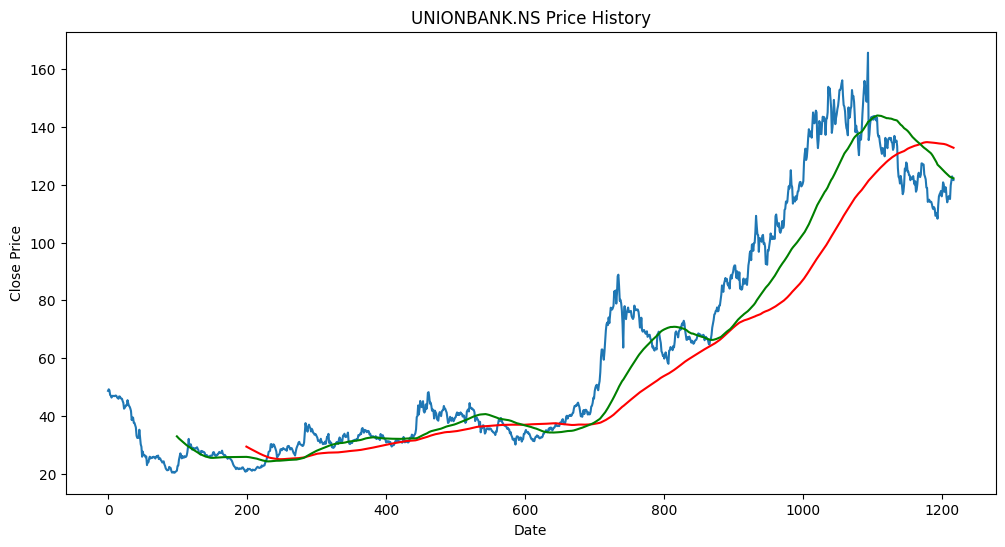

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(df.Close)
plt.plot(ma200, 'r')
plt.plot(ma100, 'g')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('UNIONBANK.NS Price History')
plt.show()

In [19]:
df.shape

(1217, 5)

In [22]:
# Splitting the data into training and testing
training_data_len = int(len(df) * 0.70) # Calculate the length for splitting
data_training = df[['Close']][:training_data_len].copy() # Select 'Close' column and slice, create a copy
data_testing = df[['Close']][training_data_len:].copy()  # Select 'Close' column and slice, create a copy

print(data_training.shape)
print(data_testing.shape)

(851, 1)
(366, 1)


In [23]:
data_training.head()


Price,Close
Ticker,UNIONBANK.NS
0,48.708157
1,49.243900
2,48.886742
3,47.279507
4,47.056274


In [24]:
data_testing.head()

Price,Close
Ticker,UNIONBANK.NS
851,68.002426
852,68.190926
853,67.625412
854,67.625412
855,67.578285


In [27]:
!pip install scikit-learn # Install the scikit-learn library if it's not installed.
from sklearn.preprocessing import MinMaxScaler # Import MinMaxScaler from the correct submodule.
scaler = MinMaxScaler(feature_range=(0, 1))
data_training_array = scaler.fit_transform(data_training)
data_training_array

array([[4.13358458e-01],
       [4.21182258e-01],
       [4.15966447e-01],
       [3.92494991e-01],
       [3.89234991e-01],
       [3.79455269e-01],
       [3.87279013e-01],
       [3.88583036e-01],
       [3.87279013e-01],
       [3.86627058e-01],
       [3.88583036e-01],
       [3.89887002e-01],
       [3.87931025e-01],
       [3.80107225e-01],
       [3.76847280e-01],
       [3.73587336e-01],
       [3.85323147e-01],
       [3.84671080e-01],
       [3.78151247e-01],
       [3.73587336e-01],
       [3.73587336e-01],
       [3.61851636e-01],
       [3.52723869e-01],
       [3.23384536e-01],
       [3.27948392e-01],
       [3.34468281e-01],
       [3.40988114e-01],
       [3.40336103e-01],
       [3.66415547e-01],
       [3.50767892e-01],
       [3.38380181e-01],
       [3.33816270e-01],
       [3.24688503e-01],
       [3.11648781e-01],
       [2.66009892e-01],
       [2.78397603e-01],
       [2.78397603e-01],
       [2.52318215e-01],
       [2.51666204e-01],
       [2.40582404e-01],


In [28]:
x_train=[]
y_train=[]
for i in range(100,data_training_array.shape[0]):
  x_train.append(data_training_array[i-100:i])
  y_train.append(data_training_array[i,0])
x_train,y_train = np.array(x_train),np.array(y_train)

In [30]:
#ml model
from tensorflow.keras.layers import Dense, Dropout, LSTM  # Import from tensorflow.keras
from tensorflow.keras.models import Sequential

model = Sequential()

model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=60, activation='relu', return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=80, activation='relu', return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units=120, activation='relu'))
model.add(Dropout(0.5))

# Add a Dense output layer
model.add(Dense(units=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [33]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100, 50)             │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100, 50)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100, 60)             │          26,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100, 60)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 100, 80)             │          45,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 100, 80)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 120)                 │          96,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 178,761 (698.29 KB)

 Trainable params: 178,761 (698.29 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=50)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 314ms/step - loss: 0.0695
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.0155
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0123
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0097
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0074
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0075
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0066
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0066
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0058
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0064
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0067
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0060
Epoch 13/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0054
Epoch 14/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0055
Epoch 15/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0050
Ep

In [35]:
model.save('keras_model.h5')

In [36]:
 data_testing .head()

Price,Close
Ticker,UNIONBANK.NS
851,68.002426
852,68.190926
853,67.625412
854,67.625412
855,67.578285


In [37]:
data_testing.tail()

Price,Close
Ticker,UNIONBANK.NS
1212,119.790001
1213,121.400002
1214,122.879997
1215,121.690002
1216,121.620003


In [40]:
past_100 = data_training.tail(100)
final = pd.concat([past_100, data_testing], ignore_index=True)

In [41]:
final.head()

Price,Close
Ticker,UNIONBANK.NS
0,76.155174
1,76.343674
2,74.552895
3,73.940254
4,73.563255


In [45]:
past_100 = data_training.tail(100)
final_df = pd.concat([past_100, data_testing], ignore_index=True) # Assign the concatenated DataFrame to 'final_df'
final_df.tail()

input_data = scaler.fit_transform(final_df)
input_data

array([[0.16823829],
       [0.16999074],
       [0.15334215],
       [0.14764653],
       [0.14414163],
       [0.15027531],
       [0.18707738],
       [0.17393377],
       [0.17218132],
       [0.17524816],
       [0.17218132],
       [0.1743719 ],
       [0.1669239 ],
       [0.14720847],
       [0.11654008],
       [0.1178544 ],
       [0.14808473],
       [0.10821575],
       [0.10339646],
       [0.10777762],
       [0.10865388],
       [0.10208207],
       [0.09726271],
       [0.09594846],
       [0.10471078],
       [0.08674787],
       [0.08937658],
       [0.09288148],
       [0.09331968],
       [0.08149038],
       [0.07710922],
       [0.06966115],
       [0.05257447],
       [0.05607948],
       [0.04600266],
       [0.04249766],
       [0.04950763],
       [0.04994576],
       [0.04600266],
       [0.094634  ],
       [0.09288148],
       [0.10339646],
       [0.09331968],
       [0.07842361],
       [0.06703244],
       [0.04030708],
       [0.03504966],
       [0.025

In [46]:
input_data.shape

(466, 1)

In [48]:
x_test=[]
y_test =[]
for i in range(100,input_data.shape[0]):
  x_test.append(input_data[i-100:i]) # Replace 'range' with 'i'
  y_test.append(input_data[i,0])    # Replace 'range' with 'i'

In [49]:
x_test,y_test= np.array(x_test),np.array(y_test)
print(x_test.shape)
print(y_test.shape)

(366, 100, 1)
(366,)


In [50]:
#making predction
y_predicted = model.predict(x_test)
y_predicted.shape

12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 266ms/step


(366, 1)

In [51]:
y_predicted

array([[0.0770656 ],
       [0.07889786],
       [0.08113229],
       [0.08355414],
       [0.08593788],
       [0.08810873],
       [0.08996034],
       [0.09143583],
       [0.09241565],
       [0.09284298],
       [0.09277449],
       [0.09227892],
       [0.09144022],
       [0.09032081],
       [0.08893632],
       [0.08728883],
       [0.08545581],
       [0.08358597],
       [0.08193918],
       [0.08092196],
       [0.08095608],
       [0.08243471],
       [0.08545659],
       [0.08975627],
       [0.09483692],
       [0.10030311],
       [0.10609671],
       [0.11235555],
       [0.11935887],
       [0.12694043],
       [0.13472643],
       [0.14235057],
       [0.1498932 ],
       [0.1579494 ],
       [0.16670868],
       [0.17595604],
       [0.18560648],
       [0.19563016],
       [0.20597203],
       [0.21622701],
       [0.22594804],
       [0.23441538],
       [0.24095795],
       [0.24534163],
       [0.24740706],
       [0.24777117],
       [0.24739242],
       [0.246

In [52]:
scaler.scale_

array([0.00929684])

In [54]:
scale_factor = 1 / 0.00929684  # Directly divide by the float value
y_predicted = y_predicted * scale_factor
y_test = y_test * scale_factor

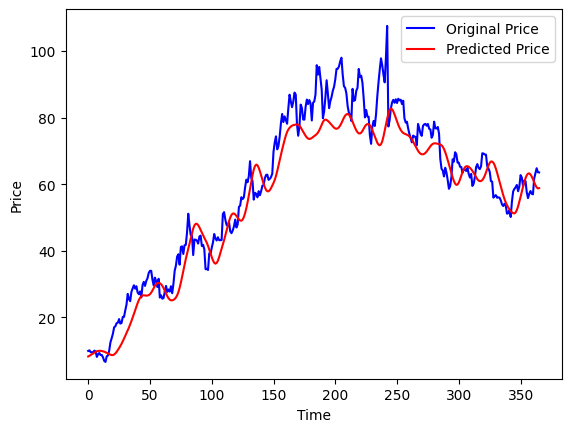

In [55]:
plt.plot(y_test, 'b', label='Original Price')
plt.plot(y_predicted, 'r', label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()